In [1]:
import pandas as pd #Mengolah data seperti excel
import tweepy #Diinstal dulu di anaconda prompt dengan run-> pip install tweepy
import nltk
import re

import matplotlib.pyplot as pl
from sklearn.feature_extraction.text import CountVectorizer #Menghitung frekuensi kata yang muncul di suatu data
from sklearn.feature_extraction.text import TfidfTransformer #Pembobotan frekuensi masing-masing kata
from sklearn.model_selection import train_test_split #Fungsi utk membagi dataset menjadi data training dan test
from sklearn.model_selection import GridSearchCV #Mencari hyperparameter
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, make_scorer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fahmimn21/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Request Twitter API

In [2]:
consumer_key='hu9fhkxNEO5zmnGA7MW4vhnE8'
consumer_secret='3OC43YiiKGnARsKzmh1KXjuNvzgepCW70i3JDiilLFlRxdiEij'

access_token='61717767-QAqtFYQgWWdJh5mNJ87hDLWrLI05vzassSQC1Td7I'
access_token_secret='tvRE5WQkmlXs2C1W9M66xK5kerlBYVFXwp0Jtqm5PTsqN'

auth=tweepy.OAuthHandler(consumer_key,consumer_secret) #Akses akun twitter
auth.set_access_token(access_token,access_token_secret) #Akses twitter general
api = tweepy.API(auth,wait_on_rate_limit=True) #Autentikasi twitter API

# Define Function Untuk Scrapping dan Text Preprocessing

In [3]:
def scrappe(keyword,count,since,until): #Input: kata kunci, jumlah tweet yang diinginkan, tanggal awal, tanggal akhir
    text_query=f"since:{since} until:{until} {keyword}" #Query search twitter
    tweets = tweepy.Cursor(api.search,q=text_query).items(count) #Mencari tweet dengan kata kunci tertentu max seminggu sejak hari ini
    tweets_list = [[tweet.created_at, tweet.id, tweet.text, tweet.retweet_count, tweet.favorite_count, tweet.place] for tweet in tweets] #Mengambil parameter yang diperlukan
    df_tweet=pd.DataFrame(tweets_list)
    df_tweet.columns=['tanggal','id','text','rt','fav','place'] #tanggal: Tanggal tweet dipost, id: id tweet, text: isi tweet, rt: Jumlah retweet, fav: Jumlah favorit/like, coor: Koordinat lokasi
    return(df_tweet)

def proc_feature(features):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', features)
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()  
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    processed_feature = regrex_pattern.sub(r'',processed_feature)
    processed_feature = re.sub('rt',' ',processed_feature)
    processed_feature = re.sub('gak',' ',processed_feature)
    processed_feature = re.sub('http',' ',processed_feature)
    processed_feature = re.sub('https',' ',processed_feature)
    return(processed_feature)

# Mining Data/Load Data

In [4]:
#data=scrappe("ppkm",20000,"2021-07-01","2021-07-12")
#data.to_excel('Tweet_PPKM_20000.xlsx',index=False)

In [5]:
data=pd.read_excel('Tweet_PPKM_20000.xlsx')

In [6]:
data.head()

,tanggal,id,text,rt,fav,place
0,2021-07-11 23:59:59,1414373940571480064,RT @Pencerah__: Saya heran sama sebagian masya...,91,0,NaN
1,2021-07-11 23:59:57,1414373928596762880,"RT @geloraco: Dibentak Polisi saat Razia PPKM,...",1093,0,NaN
2,2021-07-11 23:59:56,1414373927070014976,https://t.co/TUSTFo80j0\n\nBeneran nih pak @jo...,0,0,NaN
3,2021-07-11 23:59:53,1414373914684236032,@shabrisabi @AREAJULID Itu kenapa skrg namanya...,5,24,NaN
4,2021-07-11 23:59:47,1414373889262572032,RT @TarizSolis: ~ Rekomendasi film pendek di Y...,4180,0,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   tanggal  20000 non-null  datetime64[ns]
 1   id       20000 non-null  int64         
 2   text     20000 non-null  object        
 3   rt       20000 non-null  int64         
 4   fav      20000 non-null  int64         
 5   place    365 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 937.6+ KB


# Data Preprocessing & Pre-computed Sentiment Score

In [8]:
#Load data list kata bersentimen negatif
neg_file=pd.read_csv('https://github.com/riochr17/Analisis-Sentimen-ID/raw/master/data/negatif.txt',header=None,delimiter='\t').values
neg_file=list(neg_file.reshape(neg_file.shape[0],))

#Load data list kata bersentimen positif
pst_file=pd.read_csv('https://github.com/riochr17/Analisis-Sentimen-ID/raw/master/data/positif.txt',header=None,delimiter='\t').values
pst_file=list(pst_file.reshape(pst_file.shape[0],))

In [9]:
#Load data list stopwords bahasa indonesia
stp_word=pd.read_csv('https://github.com/stopwords-iso/stopwords-id/raw/master/stopwords-id.txt',header=None).values

### Pada bagian ini dibuat menjadi komentar karena data sampling sudah tersimpan di excel jadi hanya perlu diload

In [10]:
#//Diambil 10000 data secara acak untuk dilakukan training data dan model test
#sample=data.sample(10000).reset_index(drop=True)
sample['text']=sample['text'].apply(lambda x: proc_feature(x)) #Filter karakter dan kata pada masing-masing data
#Penghapusan stopwords
sample['text_stpw']=sample['text'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stp_word]))

In [11]:
#Pada bagian ini, dihitung jumlah kata negatif dan positif masing-masing tweet berdasarkan list kata pada neg_file dan pst_file

post_words_count=sample['text_stpw'].apply(lambda x: len([w for w in x.split(' ') if w in pst_file]))
neg_words_count=sample['text_stpw'].apply(lambda x: len([w for w in x.split(' ') if w in neg_file]))

In [12]:
#Menghitung skor sentimen, selisih jml kata positif dan negatif
sample['sent_score']=(post_words_count-neg_words_count)
#Memberi sign utk selisih <0 -1, >0 1, dan =0 0
sample['sentiment']=sample['sent_score'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

In [103]:
#sample

In [104]:
#sample.sentiment.value_counts()

In [50]:
#sample.to_excel('Sample_Sentiment.xlsx',index=False)

### Load Data Sample

In [51]:
sample=pd.read_excel('Sample_Sentiment.xlsx')

In [52]:
sample

,tanggal,id,text,rt,fav,place,text_stpw,sent_score,sentiment
0,2021-07-11 14:32:23,1414231096099802880,hancchii ppkm ini aku lagi dirumahin sama pe...,104,0,NaN,hancchii ppkm dirumahin perusahaan gatau dip...,0,0
1,2021-07-11 22:06:37,1414345408457842944,ppkm sudah tepat ppkm rakyat sehat s co vwpcq...,0,0,NaN,ppkm ppkm rakyat sehat s co vwpcqufwk1,1,1
2,2021-07-11 12:06:39,1414194421143245056,update kehidupan mahasiswa kkn ditengah ppkm h...,0,0,NaN,update kehidupan mahasiswa kkn ditengah ppkm h...,1,1
3,2021-07-11 22:56:43,1414358017789678080,tamagosfarm make dish ว นจ นทร น เป ดคร วต อ...,24,0,NaN,tamagosfarm make dish ว นจ นทร น เป ดคร วต อ...,0,0
4,2021-07-11 12:03:38,1414193662779485952,ppkm without yea thats u,0,0,NaN,ppkm without yea thats u,0,0
...,...,...,...,...,...,...,...,...,...
9995,2021-07-11 14:21:44,1414228417629676032,kacau ni klo ppkm diperpanjang gaada pemasukan...,0,1,NaN,kacau ni klo ppkm diperpanjang gaada pemasukan...,-1,-1
9996,2021-07-11 12:53:59,1414206336577933056,pimcuu ppkm,0,0,NaN,pimcuu ppkm,0,0
9997,2021-07-11 13:14:19,1414211452685017088,1trenggalek halo sobat humas selama ppkm dar...,99,0,NaN,1trenggalek halo sobat humas ppkm darurat ke...,3,1
9998,2021-07-11 12:47:18,1414204652480983040,lodyandrian buat temen temen pekerja yang di...,794,0,NaN,lodyandrian temen temen pekerja dirumahkan g...,0,0


In [53]:
sample.sentiment.value_counts() #Cek jumlah data per sentimen

 0    4510
 1    2880
-1    2610
Name: sentiment, dtype: int64

# Feature Extraction

In [15]:
vectorizer = CountVectorizer(max_features=700) #Max jumlah feature= 700 tiap data
X=vectorizer.fit_transform(sample.text_stpw).toarray()
tfid=TfidfTransformer() #Memisahkan kata menjadi satu feature
X=tfid.fit_transform(X).toarray() #Konversi kata ke angka

In [16]:
#Split dataset ke training dan test
X_train, X_test, y_train, y_test = train_test_split(X, sample.sentiment, test_size=0.2, random_state=42)

## Training Data with Models

### Gaussian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB #Import model
NB=GaussianNB() #Definisi model
NB.fit(X_train,y_train) #Fitting model
y_pred_NB=NB.predict(X_test) #Memprediksi output dengan data test
print(classification_report(y_test,y_pred_NB)) #Perhitungan metrik
print('Akurasi:',accuracy_score(y_test,y_pred_NB)) #Perhitungan akurasi
print ('AUC score:',roc_auc_score(y_test,NB.predict_proba(X_test),multi_class='ovo')) #Perhitungan score AUC untuk mendetek apakah model fit atau tidak

              precision    recall  f1-score   support

          -1       0.66      0.85      0.74       518
           0       0.92      0.29      0.44       935
           1       0.50      0.94      0.65       547

    accuracy                           0.61      2000
   macro avg       0.69      0.69      0.61      2000
weighted avg       0.73      0.61      0.57      2000

Akurasi: 0.611
AUC score: 0.8341056684184976


### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
#Melakukan hyperparameter utk mencari kombinasi parameter yang terbaik
best_DT=GridSearchCV(DecisionTreeClassifier(),{'criterion':['gini','entropy'],'splitter':['random','best']},cv=10,n_jobs=4,verbose=4)
#Fitting data dengan model yang terhyperparameter
best_DT.fit(X_train,y_train)

#Definisi model dengan parameter yang terbaik
DT=DecisionTreeClassifier(criterion=best_DT.best_params_['criterion'],splitter=best_DT.best_params_['splitter'])
DT.fit(X_train,y_train)
y_pred_DT=DT.predict(X_test)
print(classification_report(y_test,y_pred_DT))
print('Akurasi:',accuracy_score(y_test,y_pred_DT))
print ('AUC score:',roc_auc_score(y_test,DT.predict_proba(X_test),multi_class='ovo'))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85       518
           0       0.86      0.87      0.87       935
           1       0.87      0.88      0.87       547

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Akurasi: 0.864
AUC score: 0.9032335223189077


### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
best_LogR=GridSearchCV(LogisticRegression(),{'penalty':['l1','l2','elasticnet'],'solver':['newton-cg','lbfgs','liblinear','sag','saga']},cv=10,n_jobs=4,verbose=4)
best_LogR.fit(X_train,y_train)
LogR=LogisticRegression(penalty=best_LogR.best_params_['penalty'],solver=best_LogR.best_params_['solver'])
LogR.fit(X_train,y_train)
y_pred_LogR=LogR.predict(X_test)
print(classification_report(y_test,y_pred_LogR))
print('Akurasi:',accuracy_score(y_test,y_pred_LogR))
print ('AUC score:',roc_auc_score(y_test,LogR.predict_proba(X_test),multi_class='ovo'))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


/Users/fahmimn21/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [    nan     nan 0.858       nan 0.8635  0.8505  0.8505  0.84575 0.8505
 0.8505      nan     nan     nan     nan     nan]
  warnings.warn(
/Users/fahmimn21/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

          -1       0.90      0.80      0.85       518
           0       0.82      0.91      0.87       935
           1       0.92      0.84      0.88       547

    accuracy                           0.87      2000
   macro avg       0.88      0.85      0.86      2000
weighted avg       0.87      0.87      0.87      2000

Akurasi: 0.8655
AUC score: 0.9538777643573858


/Users/fahmimn21/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Support Vector Classifier (SVC)

In [20]:
from sklearn.svm import SVC
best_SVC=GridSearchCV(SVC(),{'kernel':['linear','poly','rbf','sigmoid']},cv=10,n_jobs=4,verbose=4)
best_SVC.fit(X_train,y_train)
SVC_=SVC(kernel=best_SVC.best_params_['kernel'],probability=True)
SVC_.fit(X_train,y_train)
y_pred_SVC=SVC_.predict(X_test)
print(classification_report(y_test,y_pred_SVC))
print('Akurasi:',accuracy_score(y_test,y_pred_SVC))
print ('AUC score:',roc_auc_score(y_test,SVC_.predict_proba(X_test),multi_class='ovo'))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
              precision    recall  f1-score   support

          -1       0.93      0.80      0.86       518
           0       0.82      0.94      0.88       935
           1       0.94      0.84      0.89       547

    accuracy                           0.88      2000
   macro avg       0.90      0.86      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Akurasi: 0.877
AUC score: 0.9566597305816575


### Artificial Neural Network

In [21]:
from sklearn.neural_network import MLPClassifier
best_MLP=GridSearchCV(MLPClassifier(),{'activation':['identity','logistic','tanh','relu'],'solver':['lbfgs','sgd','adam'],'learning_rate':['constant','invscaling','adaptive']},cv=10,n_jobs=4,verbose=4)
best_MLP.fit(X_train,y_train)
MLP=MLPClassifier(activation=best_MLP.best_params_['activation'],solver=best_MLP.best_params_['solver'],learning_rate=best_MLP.best_params_['learning_rate'])
MLP.fit(X_train,y_train)
y_pred_MLP=MLP.predict(X_test)
print(classification_report(y_test,y_pred_MLP))
print('Akurasi:',accuracy_score(y_test,y_pred_MLP))
print ('AUC score:',roc_auc_score(y_test,MLP.predict_proba(X_test),multi_class='ovo'))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/Users/fahmimn21/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.86      0.85      0.86       518
           0       0.86      0.86      0.86       935
           1       0.86      0.88      0.87       547

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Akurasi: 0.862
AUC score: 0.9576136231367977


/Users/fahmimn21/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### K-Neighrest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
best_KNN=GridSearchCV(KNeighborsClassifier(),{'n_neighbors':list(range(3,100)),'weights':['uniform','distance']},cv=10,n_jobs=4,verbose=4)
best_KNN.fit(X_train,y_train)
KNN=KNeighborsClassifier(n_neighbors=best_KNN.best_params_['n_neighbors'],weights=best_KNN.best_params_['weights'])
KNN.fit(X_train,y_train)
y_pred_KNN=KNN.predict(X_test)
print(classification_report(y_test,y_pred_KNN))
print('Akurasi:',accuracy_score(y_test,y_pred_KNN))
print ('AUC score:',roc_auc_score(y_test,KNN.predict_proba(X_test),multi_class='ovo'))

Fitting 10 folds for each of 194 candidates, totalling 1940 fits
              precision    recall  f1-score   support

          -1       0.94      0.73      0.82       518
           0       0.76      0.95      0.84       935
           1       0.94      0.74      0.83       547

    accuracy                           0.83      2000
   macro avg       0.88      0.81      0.83      2000
weighted avg       0.85      0.83      0.83      2000

Akurasi: 0.834
AUC score: 0.9516669103802129


### Model yang terbaik adalah model yang akurasinya paling besar, presisi tiap kelas tidak begitu jauh perbedaannya dan AUC score paling mendekati 1 sehingga dipilih Artificial Neural Network

# Prediksi data dengan model ANN

In [23]:
X=data['text'].apply(lambda x: proc_feature(x)) #Filter karakter dan beberapa kata
X=X.apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stp_word])) #Penghapusan stopwords tiap tweet
X=CountVectorizer(max_features=700).fit_transform(X).toarray() #Ubah kalimat menjadi vektor
X=tfid.fit_transform(X).toarray() #Konversi kata menjadi angka

In [24]:
data['sentimen']=MLP.predict(X) #Memprediksi data keseluruhan

<AxesSubplot:>

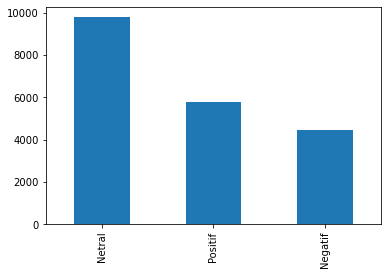

In [25]:
data['sentimen'].replace({-1:'Negatif',0:'Netral',1:'Positif'}).value_counts().plot(kind='bar') #Mengganti sentiment sign ke kategori

# Analisa Data

In [26]:
data['sentimen']=data['sentimen'].replace({-1:'Negatif',0:'Netral',1:'Positif'})

<AxesSubplot:title={'center':'Analisa Sentimen Tweet Keyword: PPKM'}, ylabel='sentimen'>

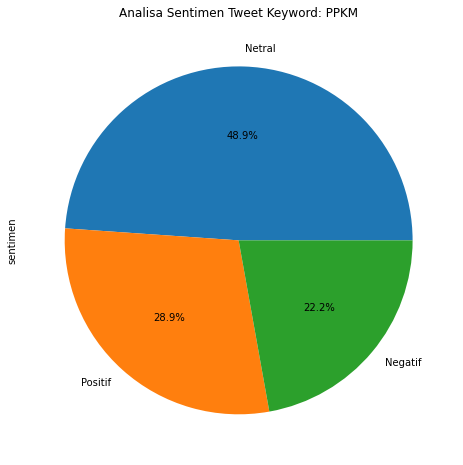

In [27]:
data['sentimen'].value_counts().plot(kind='pie',figsize=(16,8),autopct='%1.1f%%',title='Analisa Sentimen Tweet Keyword: PPKM')

In [31]:
data['processed']=data['text'].apply(lambda x: proc_feature(x))
data['processed']=data['processed'].apply(lambda x: ' '.join([item for item in x.split(' ') if item not in stp_word]))

In [41]:
#Definisi list kata-kata yang berada di tweet pada masing2 kategori
netral_words=[]
positif_words=[]
negatif_words=[]

#Memasukkan kata-kata yang berada pada semua tweet untu masing-masing kategori
for txt in data['processed'][data['sentimen']=='Netral']:
    for wrd in txt.split(' '):
        netral_words.append(wrd)

for txt in data['processed'][data['sentimen']=='Positif']:
    for wrd in txt.split(' '):
        positif_words.append(wrd)
        
for txt in data['processed'][data['sentimen']=='Negatif']:
    for wrd in txt.split(' '):
        negatif_words.append(wrd)

#mengubah list menjadi pandas Series dan menghilangkan string kosong ''
netral_wd=pd.Series(netral_words)[pd.Series(netral_words)!='']
positif_wd=pd.Series(positif_words)[pd.Series(positif_words)!='']
negatif_wd=pd.Series(negatif_words)[pd.Series(negatif_words)!='']

<AxesSubplot:title={'center':'Top 40 Kata pada Sentimen Netral'}>

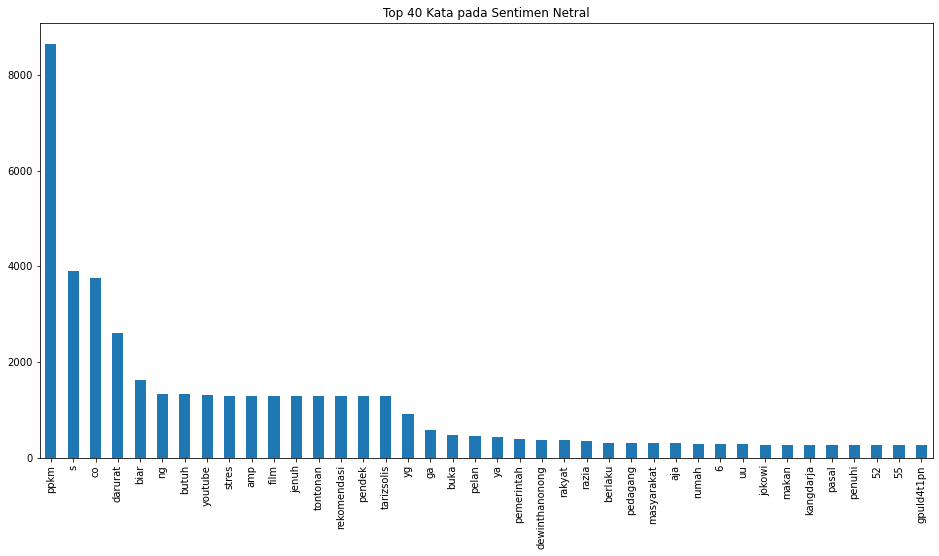

In [47]:
netral_wd.value_counts()[:40].plot(kind='bar',title='Top 40 Kata pada Sentimen Netral',figsize=(16,8))

<AxesSubplot:title={'center':'Top 40 Kata pada Sentimen Positif'}>

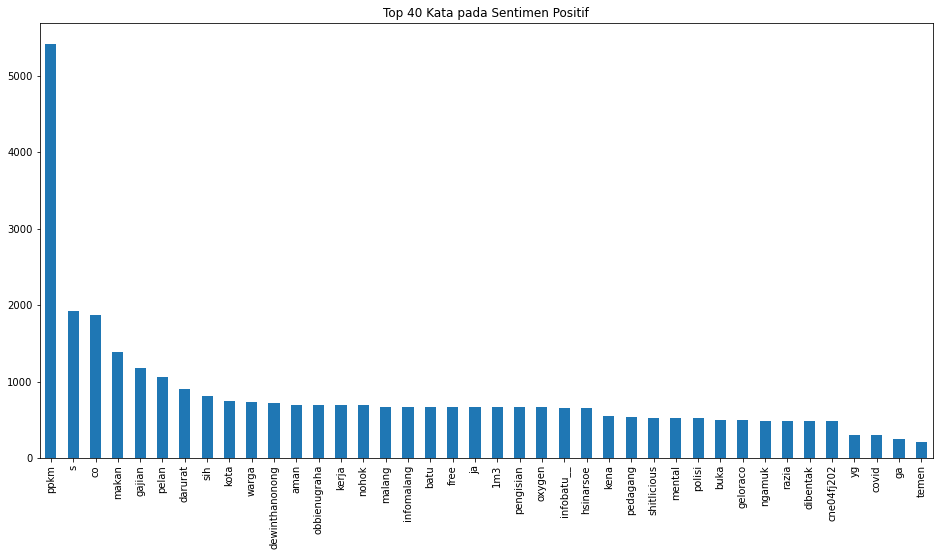

In [48]:
positif_wd.value_counts()[:40].plot(kind='bar',title='Top 40 Kata pada Sentimen Positif',figsize=(16,8))

<AxesSubplot:title={'center':'Top 40 Kata pada Sentimen Negatif'}>

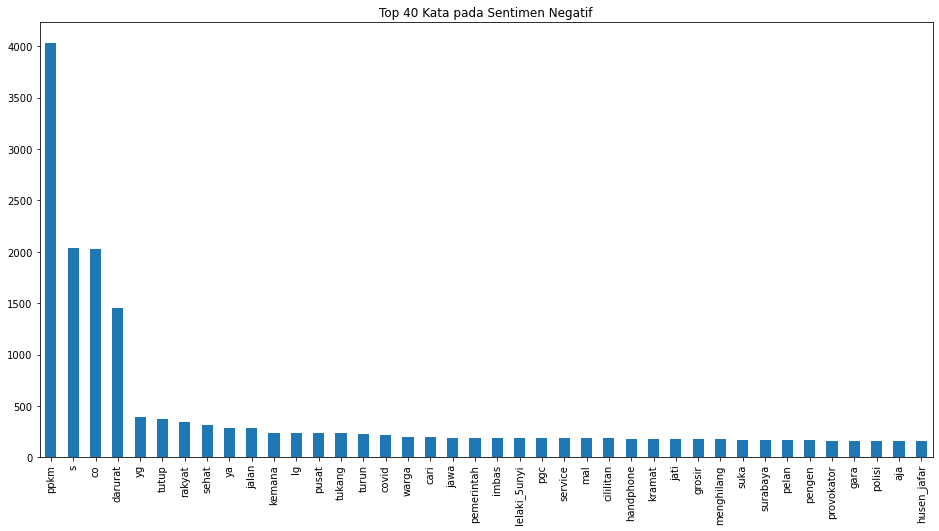

In [49]:
negatif_wd.value_counts()[:40].plot(kind='bar',title='Top 40 Kata pada Sentimen Negatif',figsize=(16,8))

In [83]:
#Pengambilan nama daerah pada kolom place karena bentuk data place berupa xml
data['city']=data['place'].dropna().apply(lambda x: x.split(', ')[4][5:])

<AxesSubplot:title={'center':'10 Top Daerah dengan Sentimen Negatif'}>

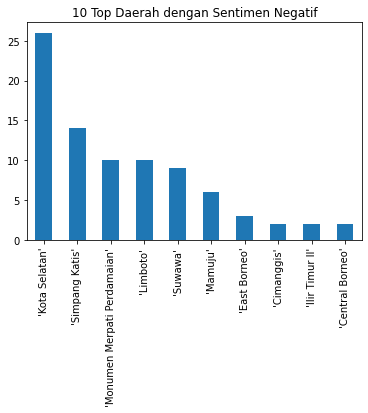

In [91]:
data[data['sentimen']=='Negatif']['city'].value_counts()[:10].plot(kind='bar',title='10 Top Daerah dengan Sentimen Negatif')

<AxesSubplot:title={'center':'10 Top Daerah dengan Sentimen Positif'}>

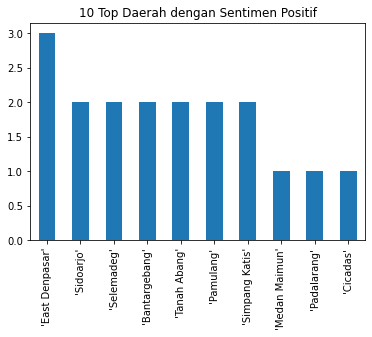

In [93]:
data[data['sentimen']=='Positif']['city'].value_counts()[:10].plot(kind='bar',title='10 Top Daerah dengan Sentimen Positif')

<AxesSubplot:title={'center':'10 Top Daerah dengan Sentimen Netral'}>

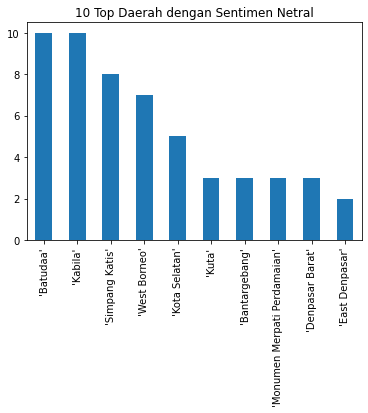

In [94]:
data[data['sentimen']=='Netral']['city'].value_counts()[:10].plot(kind='bar',title='10 Top Daerah dengan Sentimen Netral')

<AxesSubplot:title={'center':'Retweet'}, xlabel='sentimen'>

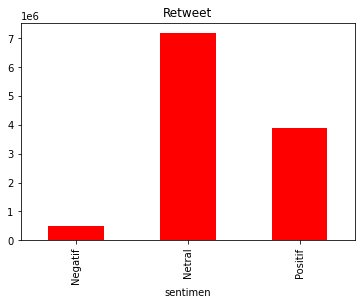

In [98]:
data.groupby('sentimen').sum()['rt'].plot(kind='bar',color='red',title='Retweet')

<AxesSubplot:title={'center':'Favorite'}, xlabel='sentimen'>

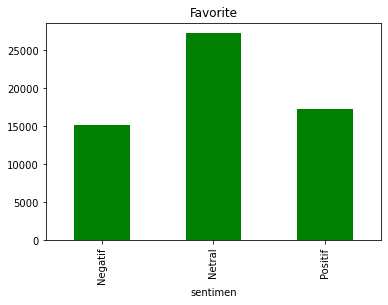

In [126]:
data.groupby('sentimen').sum()['fav'].plot(kind='bar',color='green',title='Favorite')

## Top 3 Tweet Berdasarkan Jumlah Retweet

### Top 3 Tweet yang paling banyak diretweet untuk kategori negatif

In [119]:
print(data[data['sentimen']=='Negatif'].sort_values(by='rt')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Negatif'].sort_values(by='rt')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Negatif'].sort_values(by='rt')['text'].iloc[2])

geh! besok kan lampung ppkm darurat, nah itu mksdnya gmn ya? semua toko tutup dan jalanan ditutup atau gmn? sorry jgn salty ya beneran gtau

setelah 2 minggu sakit malah ppkm sialan

Jangan pedagang kiecil aja yg dirazia, tuh pedagang vaksin juga razia

Heboh! Razia PPKM, Video Pedagang Amuk Polis… https://t.co/MNeGTYJ0t4


### Top 3 Tweet yang paling banyak diretweet untuk kategori netral

In [120]:
print(data[data['sentimen']=='Netral'].sort_values(by='rt')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Netral'].sort_values(by='rt')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Netral'].sort_values(by='rt')['text'].iloc[2])

https://t.co/TUSTFo80j0

Beneran nih pak @jokowi

@RahayuSaraswath @JogjaUpdate Iya mbak, di tempatku satu RT oleh PPKM RT yang isoman dibuatkan WAG, supaya bisa mem… https://t.co/c2nby8MzZy

PPKM: Para Pejabat Koruptor Milyaran


### Top 3 Tweet yang paling banyak diretweet untuk kategori positif

In [122]:
print(data[data['sentimen']=='Positif'].sort_values(by='rt')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Positif'].sort_values(by='rt')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Positif'].sort_values(by='rt')['text'].iloc[2])

Bosen nih baru pindah ke Depok malah PPKM, mana belum punya teman sekitar sini, haduh

Penerapan PPKM di beberapa wilayah kejam banget y, iy tau niatnya baik spy Indonesia bs lepas dr pandemi. Tp bisa g… https://t.co/v9gaXYjxlZ

@jetsilvers @Smsl_alghozali Kesepakatan MUI, dan demi PPKM, kita usulkan untuk juara bersama Om😔


## Top 3 Tweet Berdasarkan Jumlah Favorite

### Top 3 Tweet yang paling banyak dilike untuk kategori negatif

In [123]:
print(data[data['sentimen']=='Negatif'].sort_values(by='fav')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Negatif'].sort_values(by='fav')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Negatif'].sort_values(by='fav')['text'].iloc[2])

RT @utaskala: Ppkm: Plenga plongo kaya monyet https://t.co/uQtJOxMIxf

PPKM bikin gunung" pada tutup. Tapi bukan pendaki namanya kalo ga bisa survive dalam medan apapun.

RT @zarezarezareza: Hati hati yaa lagi ppkm gini amankan keluarga kalian dari broadcast wa bantuan ppkm, nanti datanya buat pinjol.


### Top 3 Tweet yang paling banyak dilike untuk kategori netral

In [124]:
print(data[data['sentimen']=='Netral'].sort_values(by='fav')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Netral'].sort_values(by='fav')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Netral'].sort_values(by='fav')['text'].iloc[2])

https://t.co/TUSTFo80j0

Beneran nih pak @jokowi

RT @TeddyGusnaidi: MUI Sumbar Tolak Peniadaan Ibadah di Masjid saat PPKM, Teddy Gusnaidi: Bubarkan LSM Model Beginian https://t.co/9LVmLdoP…

@syandiego Maaf saya taunya PPKM mas 🙏


### Top 3 Tweet yang paling banyak dilike untuk kategori positif

In [125]:
print(data[data['sentimen']=='Positif'].sort_values(by='fav')['text'].iloc[0],end='\n\n')
print(data[data['sentimen']=='Positif'].sort_values(by='fav')['text'].iloc[1],end='\n\n')
print(data[data['sentimen']=='Positif'].sort_values(by='fav')['text'].iloc[2])

RT @Pencerah__: Saya heran sama sebagian masyarakat Indonesia. Mereka ingin pandemi berakhir, ingin beribadah secara jamaah dan berdagang n…

RT @RD_4WR1212: SURABAYA KENJERAN KISRUH Operasi PPKM darurat di Bulak Banteng, Kenjeran, Surabaya berlangsung ricuh semalam. Kericuhan ter…

RT @maspiyuaja: Sempat Bantah Anies, PT Equity Life Indonesia Akhirnya Akui Melanggar PPKM Darurat https://t.co/1xx2lr94EV https://t.co/ONp…
